In [1]:
import sys  
sys.path.insert(0, '../')
from tools.training import make_training, test_on_dataset
from imagenet_models.alexnet import alexnet

import torch.nn as nn
import torch

In [2]:
variation = "original"

In [3]:
net = alexnet(pretrained=False, progress=True, num_classes = 9)

using cuda



Finished Training
Final acc :  98.96296296296296

Accuracy Graph


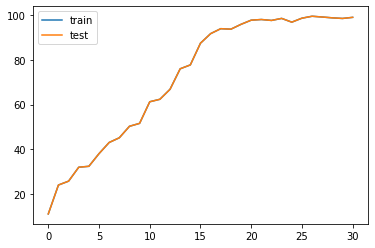


Loss Graph


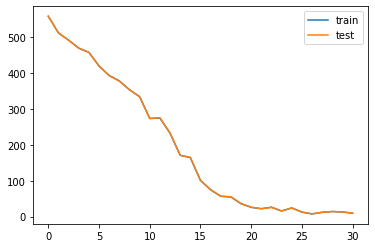

In [4]:
make_training(variation = variation, net = net, nb_epoch = 30, batch_size = 16, workers = 0, criterion = nn.CrossEntropyLoss(), test_acc_period = 10, _print = False)

In [5]:
PATH = "../models/AlexNet_"+ variation + ".pt"
torch.save(net.state_dict(), PATH)

In [6]:
for variation in ["original","mixed_same", "mixed_next", "mixed_rand", "no_fg", "only_bg_b", "only_bg_t", "only_fg"] :
    acc = test_on_dataset(variation = variation, net=net)
    print("Accuracy on ", variation, " : ", acc)

Accuracy on  original  :  98.96296296296296
Accuracy on  mixed_same  :  57.358024691358025
Accuracy on  mixed_next  :  39.876543209876544
Accuracy on  mixed_rand  :  42.04938271604938
Accuracy on  no_fg  :  31.753086419753085
Accuracy on  only_bg_b  :  18.641975308641975
Accuracy on  only_bg_t  :  26.567901234567902
Accuracy on  only_fg  :  29.11111111111111
